In [1]:
import json
import re
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.0f}'.format
import matplotlib.ticker as ticker

In [2]:
def getCommits():
    with open('../linux-commits-2023-11-12.json') as f:
        for commit in f:
            yield json.loads(commit)

In [3]:
all_commits_map = {}
for commit in getCommits():
    all_commits_map[commit['data']['commit'][0:12]] = {
        'date': commit['data']['CommitDate'],
        'author': commit['data']['Author'],
    }

In [4]:
df = pd.read_csv('links.csv')  
df.head()

,BFC_hash,BIC_hash,BFC_comment,BIC_comment,daysDistance,commitDistance
0,c56b097af26cb11c1f49a4311ba538c825666fed,5cedf721a7cdb54e9222133516c916210d836470,mm: list_lru: fix almost infinite loop causing...,list_lru: fix broken LRU_RETRY behaviour,49,3086
1,c511851de162e8ec03d62e7d7feecbdf590d881d,1c441e921201d523b5a6036aea22b0b426bf1af2,"Revert ""epoll: use freezable blocking call""",epoll: use freezable blocking call,171,25649
2,59612d187912750f416fbffe0c00bc0811c54ab5,9745cdb36da83aeec198650b410ca06304cf7928,"Revert ""select: use freezable blocking call""",select: use freezable blocking call,171,25649
3,ab1225901da2d4cd2dcbae6840e93abbef417064,2dc41281b1d1178befe4b76adf817570a7f45ec1,"Revert ""ACPI / hotplug / PCI: Avoid doing too ...",ACPI / hotplug / PCI: Avoid doing too much for...,53,11642
4,6920a1bd037374a632d585de127b6f945199dcb8,3ea67d06e4679a16f69f66f43a8d6ee4778985fc,memcg: remove incorrect underflow check,memcg: add per cgroup writeback pages accounting,49,2422


In [25]:
df['bfc_date'] = df.apply(lambda x: all_commits_map[x['BFC_hash'][0:12]]['date'], axis=1)
df['bfc_date'] = pd.to_datetime(df['bfc_date'], format='%a %b %d %H:%M:%S %Y %z', utc=True)
df['bic_date'] = df.apply(lambda x: all_commits_map[x['BIC_hash'][0:12]]['date'], axis=1)
df['bic_date'] = pd.to_datetime(df['bic_date'], format='%a %b %d %H:%M:%S %Y %z', utc=True)

### Distance in days

In [5]:
df['daysDistance'].describe()

count   90760
mean      646
std      1004
min         0
25%        45
50%       203
75%       795
max      6697
Name: daysDistance, dtype: float64

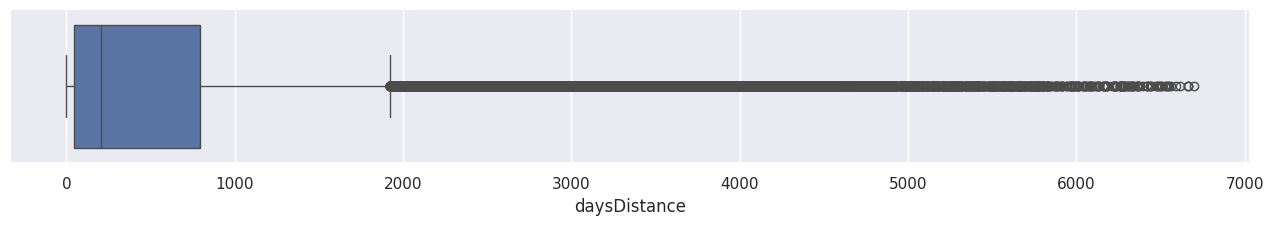

In [6]:
sns.set(rc={"figure.figsize":(16, 2)})
sns.boxplot(x=df['daysDistance'])
plt.show()

### Distance in commits

In [7]:
df['commitDistance'].describe()

count     90760
mean     140260
std      206257
min           1
25%       13765
50%       46136
75%      181358
max     1214794
Name: commitDistance, dtype: float64

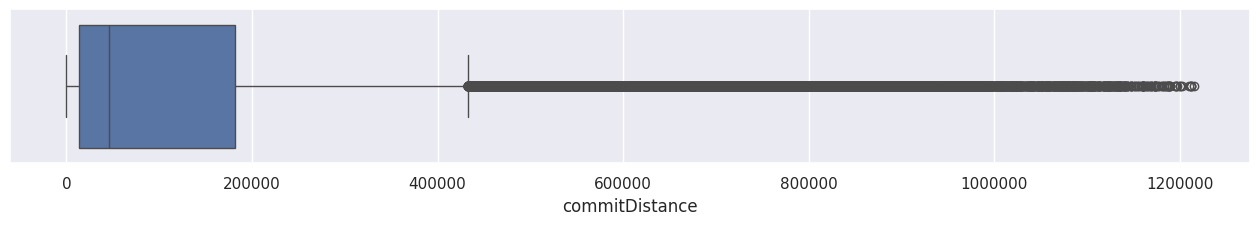

In [8]:
sns.boxplot(x=df['commitDistance'])
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

## Bugs fixed by year

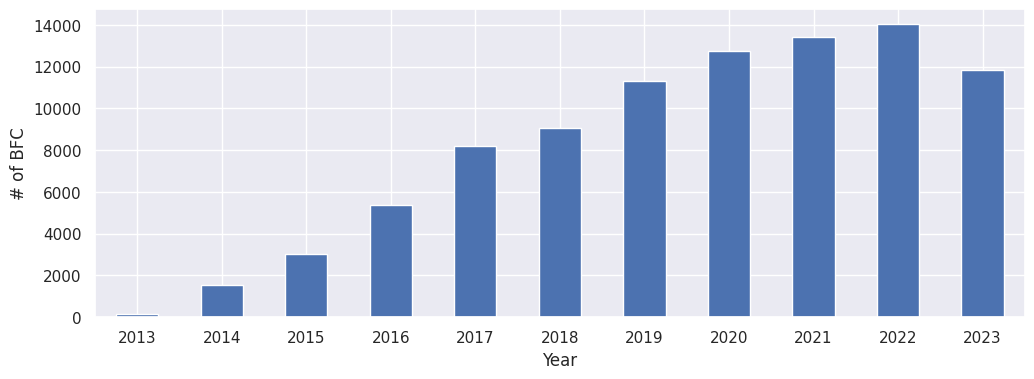

In [26]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["bfc_date"].dt.year)['bfc_date'].count().plot(kind='bar', rot=0, ax=axs)
plt.ylabel("# of BFC") 
plt.xlabel("Year");

## Bugs introduced by year

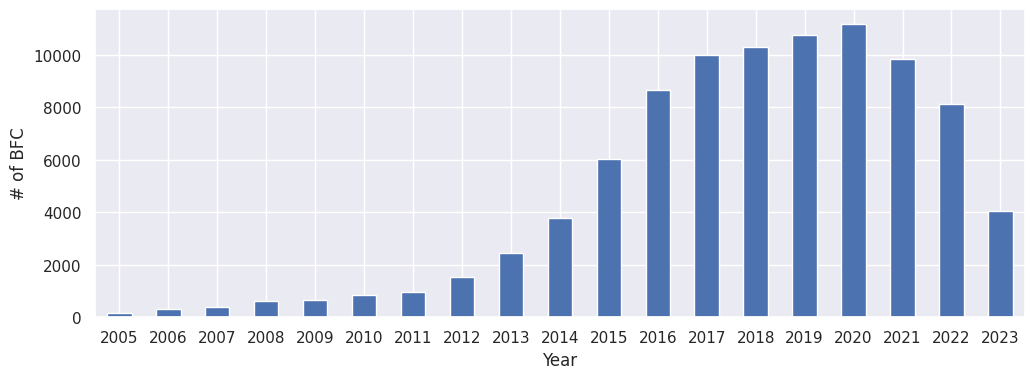

In [27]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["bic_date"].dt.year)['bic_date'].count().plot(kind='bar', rot=0, ax=axs)
plt.ylabel("# of BFC") 
plt.xlabel("Year");

## Life time of a bug fixed per year of correction

In [96]:
df['bicYearsOld'] = df.apply(lambda x: int(x['daysDistance'] / 360), axis=1)

<Axes: xlabel='bicYearsOld'>

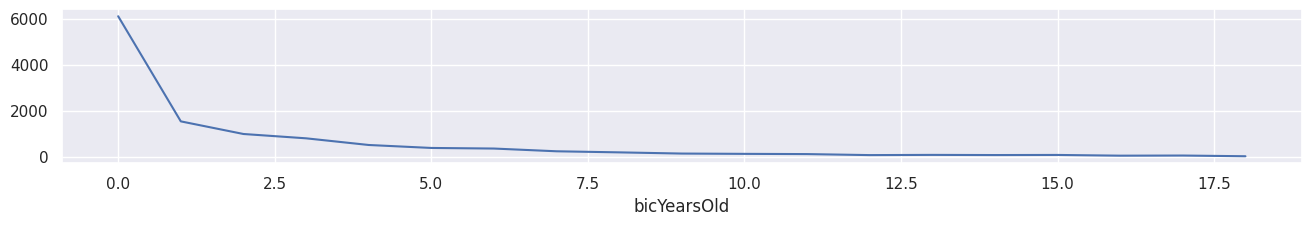

In [121]:
df_2023 = df[df['bfc_date'].dt.year == 2023].groupby(df['bicYearsOld'])['date'].count()
df_2023.plot()

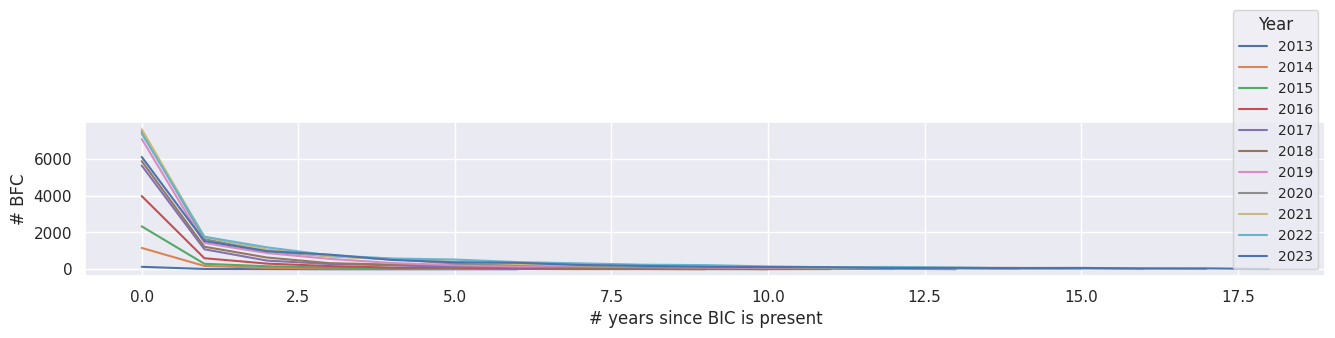

In [122]:
df_bic = df[df['bfc_date'].dt.year > 2012]
df_bic = df_bic.groupby(['bicYearsOld',df_bic["bfc_date"].dt.year]).count()['date'].unstack()
ax = df_bic.plot()
ax.set_ylabel("# BFC");
ax.set_xlabel("# years since BIC is present")
plt.legend(title="Year",loc=4, fontsize='small', fancybox=True);

## Authors of the BICs

In [131]:
df['author'] = df.apply(lambda x: all_commits_map[x['BIC_hash'][0:12]]['author'], axis=1)
authors = df.groupby(df['author'])['author'].count().sort_values(ascending=False)
print(len(authors))
authors

9142


author
Chris Wilson <chris@chris-wilson.co.uk>                                  1167
Christoph Hellwig <hch@lst.de>                                            981
David Howells <dhowells@redhat.com>                                       605
Eric Dumazet <edumazet@google.com>                                        563
Jens Axboe <axboe@kernel.dk>                                              494
                                                                         ... 
peter chang <dpf@google.com>                                                1
Aditya Kumar Singh <quic_adisi@quicinc.com>                                 1
Aditya Shankar <aditya.shankar@microchip.com>                               1
Adamski, Krzysztof (Nokia - PL/Wroclaw) <krzysztof.adamski@nokia.com>       1
Adham Faris <afaris@nvidia.com>                                             1
Name: author, Length: 9142, dtype: int64

Cuanto tiempo ha estado abierto un bug (BIC-BFC) 
- Gráfica por cada año con colores distintos

Nº caracteres del comentario

Nº de gente que está introduciendo bugs a lo largo del tiempo (cuánta gente son responsables de los BICs?)

Nº de gente involucrada


* Para el dataset de BICs:

  - BFCs que tienen BIC, por año.
  - BICs por año
  - Para los BFCs de cada año, número de BICs por año. Esto lo
podríamos poner en una gráfica donde para cada año ponemos una línea
con los BIC por año para BFCs de cada año "diferencial". Esto es, la
línea para el año 2023, por ejemplo, tendrá un punto en x=1 con y igual
al número de BICs menos de un año anteriores, en x=2 un punto con y
igual al número de BICs con entre uno y dos años de antiguedad, etc. La
línea para 2022 igual, pero con las fechas referenciadas a los BFCs de
2022, y así sucesivamente. Puede quedar una gráfica chula, que ayudaría
a saber cuánto tardan en encontrarse los bugs.
  - Tiempo entre BIC y BFC, histograma.

Además, podemos buscar algunas curiosidades, como el o los BIC que
tardaron más en tener BFC, y quizás alguna información más sobre ellos
(leyendo su hilo de correo electrónico, por ejemplo).